In [1]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image,ImageFile
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True

#Print current directory
print(f"Current directory: {os.getcwd()}")
print(f"Files in current directory: {os.listdir('.')}")

# Try to access your data paths
try:
    # Modify this path based on the output of the current directory
    data_path = os.path.join(os.getcwd(),"Data", "Data1")
    print(f"Data path exists: {os.path.exists(data_path)}")
    if os.path.exists(data_path):
        print(f"Contents of data path: {os.listdir(data_path)}")
except Exception as e:
    print(f"Error: {e}")





Current directory: /home/ubuntu/unet_env
Files in current directory: ['Data', 'Pnet.py', '.venv', 'predicted_masks', 'lib64', 'pyvenv.cfg', 'pyproject.toml', 'bin', 'etc', 'output1.png', 'lib', 'pestnet.py', 'epochVsLoss1.png', 'plant_segmentation_model.pth', 'share', 'uv.lock', 'out1.png', 'PestNet.ipynb', 'Untitled-1.ipynb', 'include']
Data path exists: True
Contents of data path: ['Natural', 'Mask']


In [3]:
def find_folders(base_path, target_folder):
    """Search for a target folder in the directory structure"""
    print(f"Searching for '{target_folder}' from base path: {base_path}")
    results = []
    
    for root, dirs, files in os.walk(base_path):
        if target_folder in dirs:
            found_path = os.path.join(root, target_folder)
            results.append(found_path)
            print(f"Found: {found_path}")
    
    return results
############################################################################################

In [4]:
class PlantDataset(Dataset):
    def __init__(self, image_path, mask_path, limit=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.limit = limit
        
        # Get image and mask files directly from the provided paths
        self.images = sorted([os.path.join(image_path, i) for i in os.listdir(image_path)])
        self.masks = sorted([os.path.join(mask_path, i) for i in os.listdir(mask_path)])
        
        if self.limit is not None:
            self.images = self.images[:self.limit]
            self.masks = self.masks[:self.limit]
            
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        
    def __getitem__(self, index):
        try:
            img = Image.open(self.images[index]).convert("RGB")
            mask = Image.open(self.masks[index]).convert("L")
            return self.transform(img), self.transform(mask)
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
        # Return a placeholder or the next valid image
            return self.__getitem__((index + 1) % len(self))

    def __len__(self):
        return len(self.images)

In [21]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder - only 2 layers
        self.enc1 = self._block(3, 64)
        self.enc2 = self._block(64, 128)
        self.enc3 = self._block(128,256)
        

        # Bottleneck
        self.bottleneck = self._block(256,512)
        
        # Decoder - only 2 layers
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(128, 64)
        
        # Output
        self.out = nn.Conv2d(64, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2)
        
    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)

        )
        
    def forward(self, x):
        # Encoder - only 3 layers
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))
        
        # Decoder - only 3 layers
        dec1 = self.up1(bottleneck)
        dec1 = torch.cat((dec1, enc3), dim=1)
        dec1 = self.dec1(dec1)
        
        dec2 = self.up2(dec1)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec3 = self.up3(dec2)
        dec3 = torch.cat((dec3, enc1), dim=1)
        dec3 = self.dec3(dec3)
        
        # Output
        out = self.out(dec3)
        return self.sigmoid(out)
#########################################################################################################

In [16]:
def train_model(model, train_loader, device, num_epochs=10):
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_history=[]
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for images, masks in train_loader:
            # Move tensors to the configured device
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        # Store the loss
        loss_history.append(avg_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')
    
    return model,loss_history

In [7]:
def visualize_predictions(model, dataset, device, num_samples=3,loss_history=None, show_overlay=True):
    model.eval()
    
    indices = random.sample(range(len(dataset)), num_samples)
    # Determine number of columns based on whether overlay is shown
    num_cols = 4 if show_overlay else 3
    
    plt.figure(figsize=(15, num_samples * 4))
    
    for i, idx in enumerate(indices):
        image, true_mask = dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            pred_mask = model(image_input)
            
        
        pred_mask = pred_mask.squeeze().cpu().numpy()
        image_np = image.permute(1, 2, 0).cpu().numpy()
        true_mask_np = true_mask.squeeze().cpu().numpy()
        
        # Plot original image
        plt.subplot(num_samples, num_cols, i * num_cols + 1)
        plt.imshow(image_np)
        plt.title("Image")
        plt.axis("off")
        
        # Plot ground truth mask
        plt.subplot(num_samples, num_cols, i * num_cols + 2)
        plt.imshow(true_mask_np, cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")
        
        # Plot predicted mask
        plt.subplot(num_samples, num_cols, i * num_cols + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")
     # Plot overlay if requested
        if show_overlay:
            plt.subplot(num_samples, num_cols, i * num_cols + 4)
            
            # Create RGB overlay
            overlay = np.zeros((image_np.shape[0], image_np.shape[1], 3))
            
            # Green channel for true mask
            overlay[:, :, 1] = true_mask_np * 0.7
            
            # Red channel for predicted mask
            overlay[:, :, 0] = pred_mask * 0.7
            
            # Yellow indicates overlap between true and predicted
            plt.imshow(overlay)
            plt.title("Overlay (Green=True, Red=Pred)")
            plt.axis("off")
    
    
    plt.tight_layout()
    plt.show()
    if loss_history is not None and len(loss_history) > 0:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
        plt.title('Training Loss vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()
#################################################################################################

In [19]:
def save_predictions(model, dataset, save_path, device):
    model.eval()
    os.makedirs(save_path, exist_ok=True)

    for idx in range(len(dataset)):
        image, _ = dataset[idx]
        image_input = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = model(image_input).squeeze().cpu().numpy()

        pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
        save_name = os.path.join(save_path, f"mask_{idx}.png")
        cv2.imwrite(save_name, pred_mask)
###################################################################################################

Using device: cpu
Current working directory: /home/ubuntu/unet_env
Searching for 'Data1' from base path: /home/ubuntu/unet_env
Found: /home/ubuntu/unet_env/Data/Data1
Using image path: /home/ubuntu/unet_env/Data/Data1/Natural
Using mask path: /home/ubuntu/unet_env/Data/Data1/Mask
Epoch 1/10, Loss: 0.6748
Epoch 2/10, Loss: 0.9445
Epoch 3/10, Loss: 0.6730
Epoch 4/10, Loss: 0.6754
Epoch 5/10, Loss: 0.6517
Epoch 6/10, Loss: 0.6486
Epoch 7/10, Loss: 0.6247
Epoch 8/10, Loss: 0.5967
Epoch 9/10, Loss: 0.5875
Epoch 10/10, Loss: 0.5804


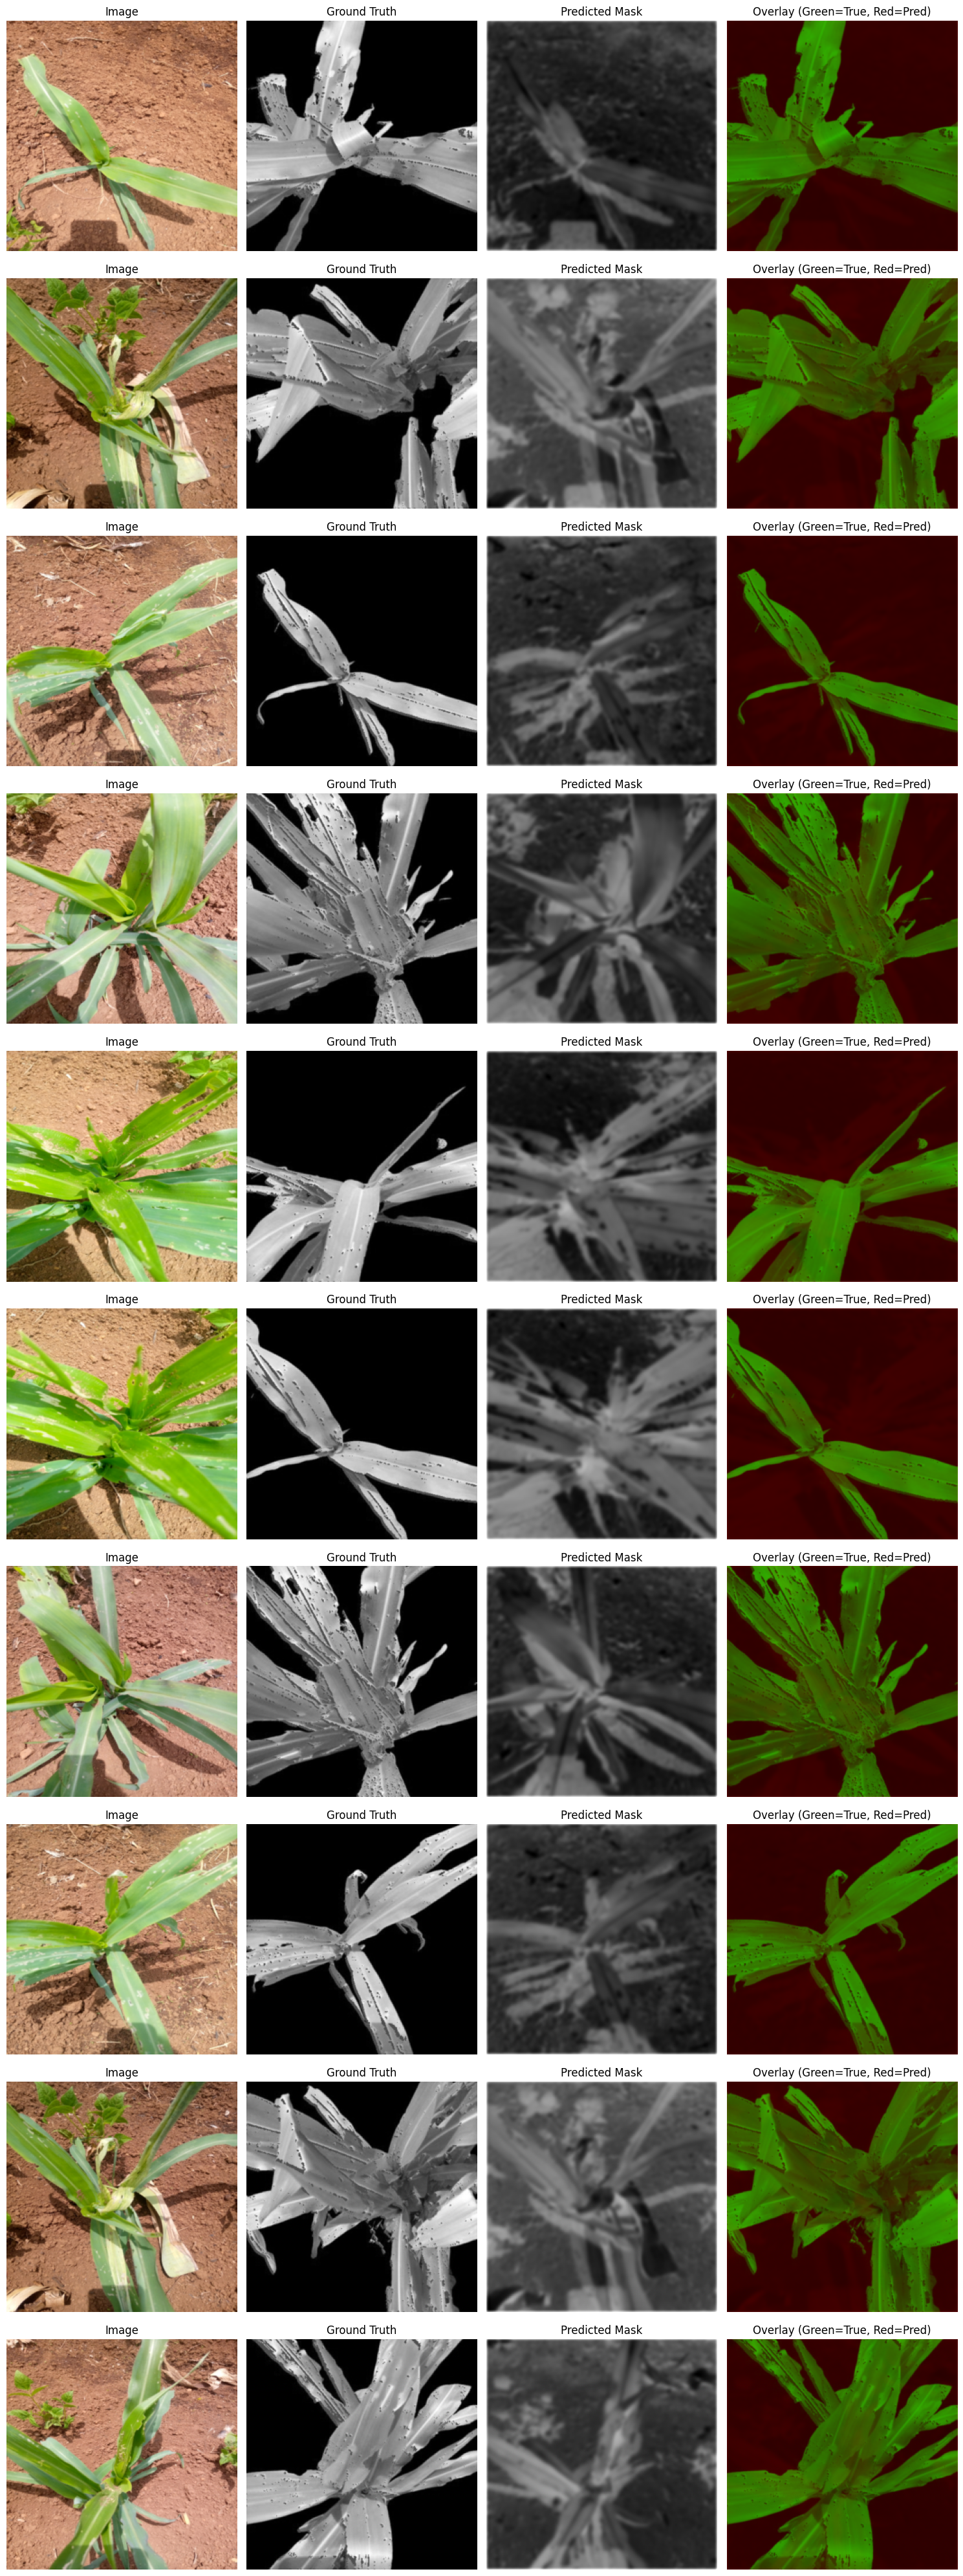

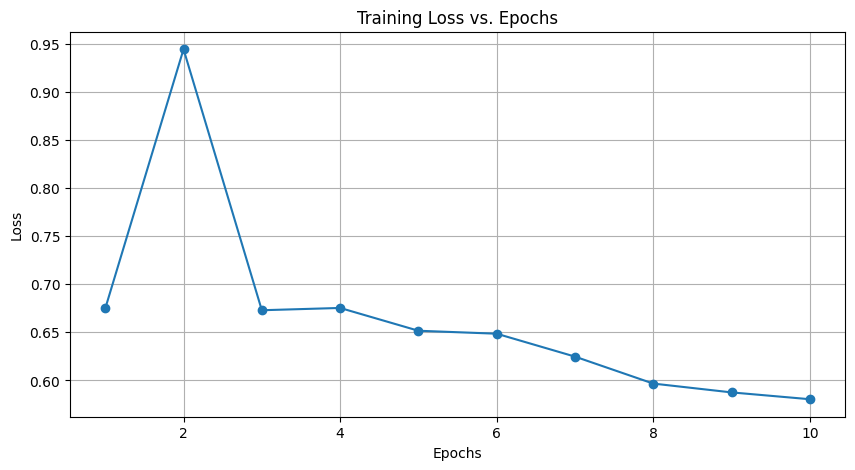

Training complete! Model saved.


In [24]:
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Get the current working directory
    base_path = os.getcwd()
    print(f"Current working directory: {base_path}")
    
    # Search for the plant_data folders
    data_paths = find_folders(base_path, "Data1")
    
    if not data_paths:
        # Try looking for specific folders
        natural_paths = find_folders(base_path, "Natural")
        mask_paths = find_folders(base_path, "Mask")
        
        if natural_paths and mask_paths:
            natural_path = natural_paths[0]
            mask_path = mask_paths[0]
        else:
            print("Could not find data folders automatically.")
            # Hard code the paths based on your screenshot
            natural_path = os.path.join(base_path, "UNET_ENV", "Data", "Data1", "Natural")
            mask_path = os.path.join(base_path, "UNET_ENV", "Data", "Data1", "Mask")
    else:
        # Construct paths based on found plant_data folder
        plant_data_path = data_paths[0]
        natural_path = os.path.join(plant_data_path, "Natural")
        mask_path = os.path.join(plant_data_path, "Mask")
    
    print(f"Using image path: {natural_path}")
    print(f"Using mask path: {mask_path}")
    
    # Check if directories exist
    if not os.path.exists(natural_path): 
        print(f"Error: Image directory not found at {natural_path}")
        return
    
    if not os.path.exists(mask_path):
        print(f"Error: Mask directory not found at {mask_path}")
        return
        
    # Create dataset and dataloader
    dataset = PlantDataset(
        image_path=natural_path,
        mask_path=mask_path,
        limit=20 # Set to an integer if you want to limit the dataset size
    )
    
    # Create data loader
    generator = torch.Generator().manual_seed(25)
    train_loader = DataLoader(
        dataset, 
        batch_size=4, 
        shuffle=True, 
        generator=generator,
        num_workers=2
    )
    
    # Create and train the model
    model = UNet().to(device)
    trained_model, loss_history = train_model(model, train_loader, device, num_epochs=10)
    
    # Save the model
    #save_predictions(trained_model, dataset, "predicted_masks", device)
    visualize_predictions(
        trained_model, 
        dataset, 
        device, 
        num_samples=10,
        loss_history=loss_history,  # Pass the loss history for plotting
        show_overlay=True  # Enable the overlay visualization
    )

    print("Training complete! Model saved.")

if __name__ == "__main__":
    main()